# How to rediscover the Higgs boson yourself - with Machine Learning!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to apply Machine Learning in search for the Higgs boson!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

Notebooks are a perfect platform to develop Machine Learning for your work, since you'll need exactly those 3 things: code, visualisations and narrative text!

We're interested in Machine Learning because we can design an algorithm to figure out for itself how to do various analyses, potentially saving us countless human-hours of design and analysis work.

Machine Learning use within high energy physics includes: 
* particle tracking
* particle identification
* signal/background classification
* and more!

This notebook will focus on signal/background classification.

By the end of this notebook you will be able to:
1. run machine learning models to classify signal and background
2. know some things you can change to improve your machine learning models

This analysis loosely follows the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1)

## 1. Load libraries

Here we will import all the required libraries for the rest of the tutorial. All scikit-learn and PyTorch functions will be imported later on when they are required. You can check the version of these packages by checking the __version__ attribute. Let’s set the random seed that we’ll be using. This reduces the randomness when you re-run the notebook.

In [1]:
# 1. Import needed libraries

import pandas as pd # to store data as dataframe
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting

print (np.__version__)
print (pd.__version__)

seed_value = 420 # 42 is the answer to life, the universe and everything
from numpy.random import seed # import the function to set the random seed in NumPy
seed(seed_value) # set the seed value for random numbers in NumPy

1.19.5
1.2.1


## 2. Load dataset for four leptons (signal and backgrounds)

The dataset we will use in this tutorial is simulated ATLAS data. Each event corresponds to 4 detected leptons: some events correspond to a Higgs Boson decay (signal) and others do not (background). Various physical quantities such as lepton charge and transverse momentum are recorded for each event. The analysis in this tutorial loosely follows the discovery of the Higgs Boson.

In [51]:
# 2. Import dataset for Higgs to 4l and backgrounds

# In this notebook we only process the main signal ggH125_ZZ4lep and the main background llll, 
# for illustration purposes. You can add other backgrounds after if you wish.
samples = ['llll','ggH125_ZZ4lep']

# get data from files
DataFrames = {} # define empty dictionary to hold dataframes
for s in samples: # loop over samples
    DataFrames[s] = pd.read_csv('Data/'+s+".csv") # read .csv file

#DataFrames['ggH125_ZZ4lep'] # print signal data to take a look

In [52]:
print(type(DataFrames['ggH125_ZZ4lep']))
print(DataFrames['ggH125_ZZ4lep'].columns)
DataFrames['ggH125_ZZ4lep'].head(5)
DataFrames['ggH125_ZZ4lep'].lep_type_0
#DataFrames['ggH125_ZZ4lep']['lep_type_0']
DataFrames['ggH125_ZZ4lep']
#type(DataFrames['ggH125_ZZ4lep'].lep_type_0)

<class 'pandas.core.frame.DataFrame'>
Index(['entry', 'lep_pt_0', 'lep_pt_1', 'lep_pt_2', 'lep_pt_3', 'lep_eta_0',
       'lep_eta_1', 'lep_eta_2', 'lep_eta_3', 'lep_phi_0', 'lep_phi_1',
       'lep_phi_2', 'lep_phi_3', 'lep_E_0', 'lep_E_1', 'lep_E_2', 'lep_E_3',
       'lep_charge_0', 'lep_charge_1', 'lep_charge_2', 'lep_charge_3',
       'lep_type_0', 'lep_type_1', 'lep_type_2', 'lep_type_3', 'lep_z0_0',
       'lep_z0_1', 'lep_z0_2', 'lep_z0_3', 'lep_sigd0_0', 'lep_sigd0_1',
       'lep_sigd0_2', 'lep_sigd0_3', 'lep_ptconerel_0', 'lep_ptconerel_1',
       'lep_ptconerel_2', 'lep_ptconerel_3', 'lep_etconerel_0',
       'lep_etconerel_1', 'lep_etconerel_2', 'lep_etconerel_3', 'min_mll',
       'mZ1', 'mZ2', 'mllll', 'totalWeight'],
      dtype='object')


,entry,lep_pt_0,lep_pt_1,lep_pt_2,lep_pt_3,lep_eta_0,lep_eta_1,lep_eta_2,lep_eta_3,lep_phi_0,...,lep_ptconerel_3,lep_etconerel_0,lep_etconerel_1,lep_etconerel_2,lep_etconerel_3,min_mll,mZ1,mZ2,mllll,totalWeight
0,0,51.905457,41.248570,16.397670,7.471228,-0.925709,-0.823695,-0.486417,0.266718,-2.774290,...,0.000000,-0.005114,0.034386,0.071266,-0.115843,9.953831,92.628607,23.311568,122.689157,0.000018
1,1,41.430645,40.307168,16.133789,7.481857,-1.233182,-0.396434,-0.541508,-0.302179,0.449031,...,0.151779,-0.030370,0.017931,0.030408,-0.120944,17.821408,86.697751,17.821408,113.659172,0.000034
2,2,33.646711,27.313271,20.035949,16.472641,-0.032324,-0.044153,0.067013,1.859531,-2.077223,...,0.000000,0.016144,-0.012675,0.101923,0.017772,32.122807,62.627431,32.122807,125.399958,0.000040
3,3,77.118562,27.845740,17.726541,14.714521,0.514764,0.845311,2.189158,0.179711,0.115437,...,0.000000,-0.005004,-0.007781,0.000000,0.034991,29.143731,84.535069,29.143731,123.645105,0.000059
4,4,161.909219,53.367754,25.596689,18.864479,-1.037354,-0.821728,-1.261883,0.126195,-0.161717,...,0.000000,0.018625,-0.000264,-0.001246,-0.002172,39.159591,68.958081,48.500839,123.518264,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164711,164711,32.143482,24.158068,17.203547,14.358152,-1.003832,0.609448,0.876340,1.039745,-0.417631,...,0.000000,-0.020921,0.040304,-0.001333,0.010283,25.926057,62.697352,39.612517,123.352912,0.000019
164712,164712,39.488273,33.694094,32.709998,14.797520,0.184790,0.799441,-0.454989,-1.167309,-0.747386,...,0.000000,0.040552,-0.000592,0.018882,-0.019414,30.654450,56.876117,30.654450,122.652688,0.000054
164713,164713,63.284211,22.707840,15.635994,14.873250,0.935591,0.184483,0.174508,2.128866,-1.503719,...,0.000000,0.010497,-0.015776,-0.022911,-0.003570,30.952590,66.649322,37.686620,124.312299,0.000071
164714,164714,52.538805,40.321457,25.766850,19.381920,0.880250,1.205615,1.701138,0.853039,-2.060255,...,0.000000,0.017046,-0.013661,0.057185,0.000224,19.868087,88.412652,19.868087,124.105421,0.000060


In [55]:
sig = DataFrames['ggH125_ZZ4lep']
bckg = DataFrames['llll']

#sig.head()
#sig.info()
print("Number of signal events:", sig.shape[0])
print("Number of background events:", bckg.shape[0])
print("Number of features:", sig.shape[1])

Number of signal events: 164716
Number of background events: 554279
Number of features: 46


## 3. Lepton cut on Nevent
Before diving into machine learning, think about whether there are any things you should do to clean up your data. In the case of this Higgs analysis, Higgs boson decays should produce 4 electrons or 4 muons or 2 electrons and 2 muons. Let’s define a function to keep only events which produce 4 electrons or 4 muons or 2 electrons and 2 muons.

In [56]:
# my own way to select events with the right leptons and charges

def lep_cut_type(df):
    lep_type_0 = df['lep_type_0']
    lep_type_1 = df['lep_type_1']
    lep_type_2 = df['lep_type_2']
    lep_type_3 = df['lep_type_3']

    sum = lep_type_0 + lep_type_1 + lep_type_2 + lep_type_3
    if (sum == 44) or (sum==52) or (sum==48):
        return True
    else: 
        return False

def lep_cut_charge(df):
    lep_charge_0 = df['lep_charge_0']
    lep_charge_1 = df['lep_charge_1']
    lep_charge_2 = df['lep_charge_2']
    lep_charge_3 = df['lep_charge_3']

    sum = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    if (sum == 0):
        return True
    else: 
        return False


sig = sig[sig.apply(lep_cut_type, axis=1)]
print(sig.shape[0])
sig = sig[sig.apply(lep_cut_charge, axis=1)]
print(sig.shape[0])

sig['sum'] = sig['lep_type_0'] + sig['lep_type_1'] + sig['lep_type_2'] + sig['lep_type_3']
sig['sum'].unique()

163754
161451


array([52, 48, 44])

In [50]:
# 3. Cut on lepton type to be eeee, or mumumumu, or eemumu

def cut_lep_type(lep_type_0,lep_type_1,lep_type_2,lep_type_3):
# first lepton is [0], 2nd lepton is [1] etc
# for an electron lep_type is 11 for a muon lep_type is 13
# only want to keep events where one of eeee, mumumumu, eemumu
    sum_lep_type = lep_type_0 + lep_type_1 + lep_type_2 + lep_type_3
    if sum_lep_type==44 or sum_lep_type==48 or sum_lep_type==52: return True
    else: return False
    
# apply cut on lepton type
for s in samples:
    # cut on lepton type using the function cut_lep_type defined above
    DataFrames[s] = DataFrames[s][ np.vectorize(cut_lep_type)(DataFrames[s].lep_type_0,
                              		                      DataFrames[s].lep_type_1,
                                          	              DataFrames[s].lep_type_2,
                                                  	      DataFrames[s].lep_type_3) ]
DataFrames['ggH125_ZZ4lep'].shape # print signal data to take a look    

# alternative way
#sig['sum'] = sig['lep_type_0'] + sig['lep_type_1'] + sig['lep_type_2'] + sig['lep_type_3']
#sig['sum'].unique()
#sig = sig[(sig['sum'] == 44) | (sig['sum'] == 52) | (sig['sum'] == 48)]

(163754, 46)

## 4. Lepton cut on charge

In [111]:
def cut_lep_charge(lep_charge_0,lep_charge_1,lep_charge_2,lep_charge_3):
# only want to keep events where sum of lepton charges is 0
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    if sum_lep_charge==0: return True
    else: return False

In [5]:
# 4. Cut on lepton charge to be 0 in all cases

def cut_lep_charge(lep_charge_0,lep_charge_1,lep_charge_2,lep_charge_3):
# only want to keep events where sum of lepton charges is 0
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    if sum_lep_charge==0: return True
    else: return False

# apply cut on lepton charge
for s in samples:
    # cut on lepton charge using the function cut_lep_charge defined above
    DataFrames[s] = DataFrames[s][ np.vectorize(cut_lep_charge)(DataFrames[s].lep_charge_0,
                                                    	    DataFrames[s].lep_charge_1,
                                                    	    DataFrames[s].lep_charge_2,
                                                    	    DataFrames[s].lep_charge_3) ]
DataFrames['ggH125_ZZ4lep'].shape # print signal data to take a look    

(161451, 46)

## 5. Plot some input variables
In any analysis searching for signal one wants to optimise the use of various input variables. Often, this optimisation will be to find the best signal to background ratio. Here we define histograms for the variables that we’ll look to optimise.

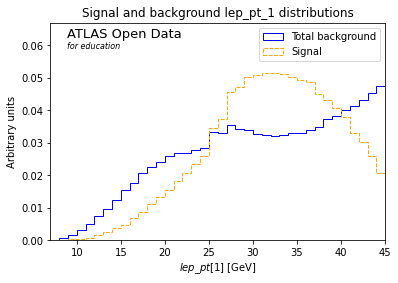

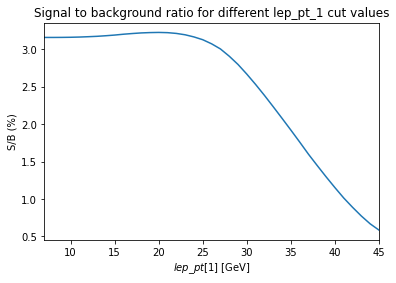

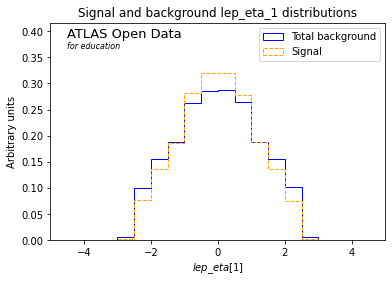

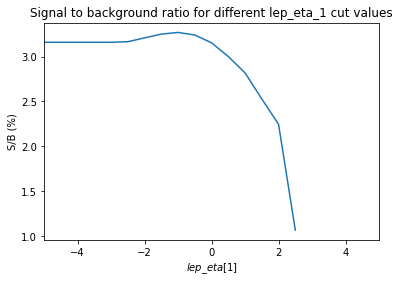

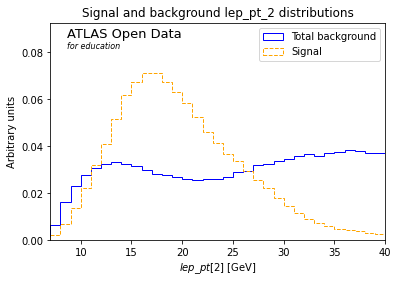

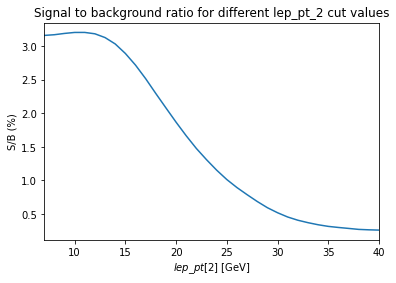

In [59]:
# 5. Plot pT distributions and cumulative S/B 


lep_pt_1 = { # dictionary containing plotting parameters for the lep_pt_1 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':38, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}
lep_eta_1 = { # dictionary containing plotting parameters for the lep_eta_1 histogram
    # change plotting parameters
    'bin_width':.5, # width of each histogram bin
    'num_bins':20, # number of histogram bins
    'xrange_min':-5, # minimum on x-axis
    'xlabel':r'$lep\_eta$[1]', # x-axis label
}

lep_pt_2 = { # dictionary containing plotting parameters for the lep_pt_2 histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':33, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[2] [GeV]', # x-axis label
}

SoverB_hist_dict = {'lep_pt_1':lep_pt_1, 'lep_eta_1':lep_eta_1, 'lep_pt_2':lep_pt_2} # add a histogram here if you want it plotted 

from my_functions import plot_SoverB
plot_SoverB(DataFrames, SoverB_hist_dict)

1. Imagine placing a cut at 7 GeV in the distributions of signal and background (1st plot). This means keeping all events above 7 GeV in the signal and background histograms.
2. We then take the ratio of the number of signal events that pass this cut, to the number of background events that pass this cut. This gives us a starting value for S/B (2nd plot).
3. We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more background than signal, so S/B increases.
4. There comes a point around 13 GeV where we start throwing away too much signal, thus S/B starts to decrease.
5. Our goal is to find the maximum in S/B, and place the cut there. You may have thought the maximum would be where the signal and background cross in the upper plot, but remember that the lower plot is the signal to background ratio of everything to the right of that x-value, not the signal to background ratio at that x-value.

## 6. Format the data for machine learning

In [73]:
# 6. convert DF to numpy array for sikitlearn and TF

ML_inputs = ['lep_pt_1','lep_pt_2'] # list of features for ML model

#  Organise data ready for the machine learning model

# for sklearn data are usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories 
# of length n_samples

all_MC = [] # define empty list that will contain all features for the MC (list of dataframes)
for s in samples: # loop over the different samples
    if s!='data': # only MC should pass this
        all_MC.append(DataFrames[s][ML_inputs]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X
print(all_MC[0].shape[0], '+', all_MC[1].shape[0], '=', all_MC[0].shape[0]+all_MC[1].shape[0], '==', X.shape[0])

all_y = [] # define empty list that will contain labels whether an event in signal or background
for s in samples: # loop over the different samples
    if s!='data': # only MC should pass this
        if 'H125' in s: # only signal MC should pass this
            all_y.append(np.ones(DataFrames[s].shape[0])) # signal events are labelled with 1
        else: # only background MC should pass this
            all_y.append(np.zeros(DataFrames[s].shape[0])) # background events are labelled 0
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

print(X.shape)
print(y.shape)

554279 + 164716 = 718995 == 718995
(718995, 2)
(718995,)


In [8]:
all_MC_sig = []
all_MC_sig.append(DataFrames['ggH125_ZZ4lep'][ML_inputs])
all_MC_sig[0].shape
print(DataFrames['llll'].shape)
print(DataFrames['ggH125_ZZ4lep'].shape)

print(DataFrames['llll']['lep_pt_1'][0])
print(DataFrames['llll']['lep_pt_2'][0])
print(DataFrames['ggH125_ZZ4lep']['lep_pt_1'][0])
print(DataFrames['ggH125_ZZ4lep']['lep_pt_2'][0])
print(X[523957])

(523957, 46)
(161451, 46)
61.67795703125
48.66644140625
41.2485703125
16.397669921875
[41.24857031 16.39766992]


## 7. Scaled training and test set 

In [76]:
# 7. define train and test sets for ML algorithm -- we also scale to normal dist

# This will split your data into train-test sets: 67%-33%. 
# It will also shuffle entries so you will not get the first 67% of X for training 
# and the last 33% for testing. 
# This is particularly important in cases where you load all signal events first 
# and then the background events.

# Here we split our data into two independent samples. 
# The split is to create a training and testing set. 
# The first will be used for classifier training and the second to evaluate its performance.

from sklearn.model_selection import train_test_split

# make train and test sets
X_train,X_test, y_train,y_test = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=seed_value) # set the random seed for reproducibility
print(X_train.shape)
#print(X_train)
print(y_train.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialise StandardScaler (The StandardScaler ensures that all numerical attributes are scaled 
                          # to have a mean of 0 and a standard deviation of 1 before they are fed to the machine learning model)

# Fit only to the training data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
#print(X_train_scaled)

# Apply the same transformation to the test set
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

(481726, 2)
(481726,)


## 8. Random Forest

In [77]:
# 8. Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# the parameters for initializing are called hyperprameters
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=seed_value) # initialise your random forest classifier
RF_clf.fit(X_train_scaled, y_train) # fit to the training data
y_pred_RF = RF_clf.predict(X_test_scaled) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_scaled)

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print(accuracy_score(y_test, y_pred_RF))
print(accuracy_score(y_train, y_pred_RF_train))

0.8140717919323637
0.8170308432594462


1. The classifier is created. In this situation we have three hyperparameters specified: criterion, max_depth (max number of consecutive cuts an individual tree can make), and n_estimators (number of decision trees used). These are not altered during training (i.e. they are not included in θ).
2. The classifier is trained using the training dataset X_train_scaled and corresponding labels y_train. During training, we give the classifier both the features (X_train_scaled) and targets (y_train) and it must learn how to map the data to a prediction. Check out this online article for more info.
3. The classifier makes predictions on the test dataset X_test_scaled. The machine learning algorithm was not exposed to these data during training.
4. An accuracy score between the test dataset y_test and machine learning predictions y_pred is made. The accuracy score is defined as the ratio of correctly identified data points to all data points.

## 9-12. Neural Network (using PyTorch)

In [79]:
# 9. NN classifier, all hyperparameters, and Dataset

import torch # import PyTorch
import torch.nn as nn # import PyTorch neural network
import torch.nn.functional as F # import PyTorch neural network functional
from torch.autograd import Variable # create variable from tensor
import torch.utils.data as Data # create data from tensors

epochs        = 10                       # number of training epochs
batch_size    = 32                       # number of samples per batch
input_size    = len(ML_inputs)           # The number of features
num_classes   = 2                        # The number of output classes. In this case: [signal, background]
hidden_size   = 5                        # The number of nodes at the hidden layer
learning_rate = 0.001                    # The speed of convergence
verbose       = True                     # flag for printing out stats at each epoch
torch.manual_seed(seed_value)            # set random seed for PyTorch

X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float) # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long) # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor) # make variables from tensors

X_valid_var, y_valid_var = X_train_var[:100], y_train_var[:100] # get first 100 events for validation
X_train_nn_var, y_train_nn_var = X_train_var[100:], y_train_var[100:] # get remaining events for training

# need train_loader for accuracy and loss calculation
train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var) # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var) # create validation dataset

train_loader = Data.DataLoader(dataset=train_data, # PyTorch Dataset
                               batch_size=batch_size, # how many samples per batch to load
                               shuffle=True) # data reshuffled at every epoch

valid_loader = Data.DataLoader(dataset=valid_data, # PyTorch Dataset
                               batch_size=batch_size, # how many samples per batch to load
                               shuffle=True) # data reshuffled at every epoch

In [80]:
'''
for batch, (x_train_batch, y_train_batch) in enumerate(train_loader): # loop over train_loader
    if batch == 0: print(batch, (x_train_batch, y_train_batch))
        
print (len(train_loader.dataset)        )
'''

'\nfor batch, (x_train_batch, y_train_batch) in enumerate(train_loader): # loop over train_loader\n    if batch == 0: print(batch, (x_train_batch, y_train_batch))\n        \nprint (len(train_loader.dataset)        )\n'

In [81]:
# 10. NN structure

class Classifier_MLP(nn.Module): # define Multi-Layer Perceptron
    def __init__(self, in_dim, hidden_dim, out_dim): # initialise
        super().__init__() # lets you avoid referring to the base class explicitly
        
        self.h1  = nn.Linear(in_dim, hidden_dim) # hidden layer 1
        self.out = nn.Linear(hidden_dim, out_dim) # output layer
        self.out_dim = out_dim # output layer dimension

    def forward(self, x): # order of the layers
        
        x = F.relu(self.h1(x)) # relu activation function for hidden layer
        x = self.out(x) # no activation function for output layer
        
        return x, F.softmax(x, dim=1) # SoftMax function
    
NN_clf = Classifier_MLP(in_dim=input_size, hidden_dim=hidden_size, out_dim=num_classes) # call Classifier_MLP class
optimizer = torch.optim.SGD(NN_clf.parameters(), lr=learning_rate) # optimize model parameters    

In [82]:
# 11. NN training 

_results = [] # define empty list for epoch, train_loss, valid_loss, accuracy

for epoch in range(epochs):  # loop over the dataset multiple times

    # training loop for this epoch
    NN_clf.train() # set the model into training mode
    
    train_loss = 0. # start training loss counter at 0
    for batch, (x_train_batch, y_train_batch) in enumerate(train_loader): # loop over train_loader
        
        NN_clf.zero_grad() # set the gradients to zero before backpropragation because PyTorch accumulates the gradients
        out, prob = NN_clf(x_train_batch) # get output and probability on this training batch
        loss = F.cross_entropy(out, y_train_batch) # calculate loss as cross entropy
        
        loss.backward() # compute dloss/dx
        optimizer.step() # updates the parameters
        
        train_loss += loss.item() * x_train_batch.size(0) # add to counter for training loss
    
    train_loss /= len(train_loader.dataset) # divide train loss by length of train_loader

    if verbose: # if verbose flag set to True
        print('Epoch: {}, Train Loss: {:4f}'.format(epoch, train_loss))

    # validation loop for this epoch:
    NN_clf.eval() # set the model into evaluation mode
    with torch.no_grad():  # turn off the gradient calculations
        
        correct = 0; valid_loss = 0 # start counters for number of correct and validation loss
        for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader): # loop over validation loader
            
            out, prob = NN_clf(x_valid_batch) # get output and probability on this validation batch
            loss = F.cross_entropy(out, y_valid_batch) # compute loss as cross entropy
            
            valid_loss += loss.item() * x_valid_batch.size(0) # add to counter for validation loss
            
            preds = prob.argmax(dim=1, keepdim=True) # get predictions
            correct += preds.eq(y_valid_batch.view_as(preds)).sum().item() # count number of correct
            
        valid_loss /= len(valid_loader.dataset) # divide validation loss by length of validation dataset
        accuracy = correct / len(valid_loader.dataset) # calculate accuracy as number of correct divided by total

    if verbose: # if verbose flag set to True
        print('Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(valid_loss, accuracy))

    # create output row:
    _results.append([epoch, train_loss, valid_loss, accuracy])

results = np.array(_results) # make array of results
print('Finished Training')
print("Final validation error: ",100.*(1 - accuracy),"%")
print("Final validation accuracy: {:4f} %".format(100*accuracy))

Epoch: 0, Train Loss: 0.454595
Validation Loss: 0.427019, Validation Accuracy: 0.830000
Epoch: 1, Train Loss: 0.414833
Validation Loss: 0.439326, Validation Accuracy: 0.830000
Epoch: 2, Train Loss: 0.410521
Validation Loss: 0.444151, Validation Accuracy: 0.830000
Epoch: 3, Train Loss: 0.408350
Validation Loss: 0.446893, Validation Accuracy: 0.830000
Epoch: 4, Train Loss: 0.406790
Validation Loss: 0.447957, Validation Accuracy: 0.830000
Epoch: 5, Train Loss: 0.405457
Validation Loss: 0.449288, Validation Accuracy: 0.830000
Epoch: 6, Train Loss: 0.404180
Validation Loss: 0.448908, Validation Accuracy: 0.830000
Epoch: 7, Train Loss: 0.402852
Validation Loss: 0.449932, Validation Accuracy: 0.830000
Epoch: 8, Train Loss: 0.401366
Validation Loss: 0.449707, Validation Accuracy: 0.830000
Epoch: 9, Train Loss: 0.399696
Validation Loss: 0.449844, Validation Accuracy: 0.840000
Finished Training
Final validation error:  16.000000000000004 %
Final validation accuracy: 84.000000 %


In [83]:
# 12. Evaluate the NN model 

X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float) # make tensor from X_test_scaled
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long) # make tensor from y_test

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor) # make variables from tensors

out, prob = NN_clf(X_test_var) # get output and probabilities from X_test
# probability above 50% is assigned as signal
y_pred_NN = prob.cpu().detach().numpy().argmax(axis=1) # get signal/background predictions

# See how well the classifier does
print(accuracy_score(y_test, y_pred_NN))

0.7781589672481445


## 13. Overfitting
Comparing a machine learning model’s output distribution for the training and testing set is a popular way in High Energy Physics to check for overfitting. The compare_train_test() method will plot the shape of the machine learning model’s decision function for each class, as well as overlaying it with the decision function in the training set. Overfitting means the model works well for training and not dfor testing sets. 

<img src="overfitting.png" width="300" height="300">



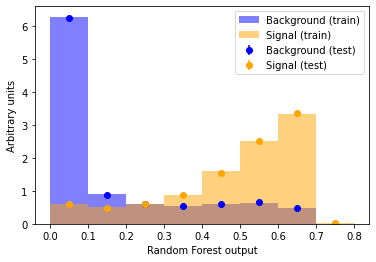

In [16]:
# 13. Check overfitting with comparing distributions
# if dots are far from bars, then there is overtraining

from my_functions import compare_train_test
compare_train_test(RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest output')

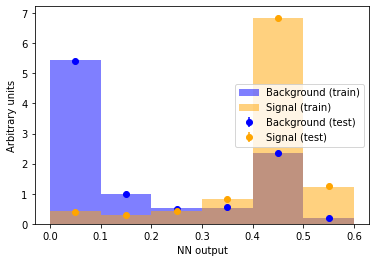

In [17]:
compare_train_test(NN_clf, X_train_scaled, y_train, X_test_scaled, y_test, 'NN output')

## 14-17. Alternative Metrics
**Precision** is defined as precision=TP/TP+FP. It is the ratio of all things that were correctly classified as positive to all things that were classified as positive. Precision itself is an imperfect metric: a trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (1/1=100%) but this would not be useful. This is equivalent to having a very high threshold. As such, precision is typically combined with another metric: recall.

**Recall** is defined as recall=TP/TP+FN. It is the ratio of all things that were correctly classified as positive to all things that should have been classified as positive. Recall itself is also an imperfect metric: a trivial way to have perfect recall is to classify everything as positive; doing so, however, would result in a poor precision score. This is equivalent to having a very low threshold. As such, precision and recall need to be considered together.

In [106]:
# 14. Metrics for our Classifier

from sklearn.metrics import classification_report, roc_auc_score
# Random Forest Report
print("RandomForest report:")
print (classification_report(y_test, y_pred_RF,
                            target_names=["background", "signal"]))
print ("----------------------------------------------------------------")                            
# Neural Network Report
print("NN report:")
print (classification_report(y_test, y_pred_NN,
                            target_names=["background", "signal"])) 

print("signal / Total event =",sig.shape[0]/(sig.shape[0] + bckg.shape[0]), "%")                            

# Get probabilties for RF and NN
decisions_rf = RF_clf.predict_proba(X_test_scaled)[:,1] # get the decisions of the random forest 
decisions_nn = NN_clf(X_test_var)[1][:,1].cpu().detach().numpy() # get the decisions of the neural network

RandomForest report:
              precision    recall  f1-score   support

  background       0.87      0.89      0.88    182844
      signal       0.61      0.54      0.57     54425

    accuracy                           0.81    237269
   macro avg       0.74      0.72      0.73    237269
weighted avg       0.81      0.81      0.81    237269

----------------------------------------------------------------
NN report:
              precision    recall  f1-score   support

  background       0.78      0.99      0.87    182844
      signal       0.66      0.07      0.12     54425

    accuracy                           0.78    237269
   macro avg       0.72      0.53      0.50    237269
weighted avg       0.75      0.78      0.70    237269

signal / Total event = 0.22557528677015076 %


In [104]:
print(decisions_rf[y_test==0].shape)
print(decisions_rf[y_test==1].shape)
print(decisions_rf.shape)

(182844,)
(54425,)
(237269,)


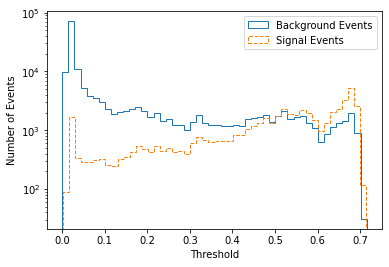

In [37]:
# 15. Signal and Background weight distributions for RF and NN

plt.hist(decisions_rf[y_test==0], histtype='step', bins=50, label='Background Events') # plot background
plt.hist(decisions_rf[y_test==1], histtype='step', bins=50, linestyle='dashed', label='Signal Events') # plot signal
plt.xlabel('Threshold') # x-axis label
plt.ylabel('Number of Events') # y-axis label
plt.semilogy() # make the y-axis semi-log
plt.legend() # draw the legend

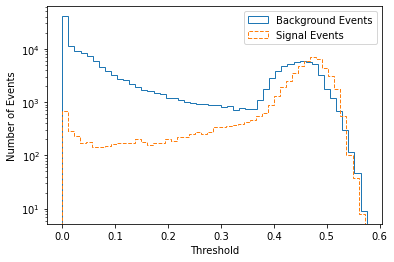

In [57]:
plt.hist(decisions_nn[y_test==0], histtype='step', bins=50, label='Background Events') # plot background
plt.hist(decisions_nn[y_test==1], histtype='step', bins=50, linestyle='dashed', label='Signal Events') # plot signal
plt.xlabel('Threshold') # x-axis label
plt.ylabel('Number of Events') # y-axis label
plt.semilogy() # make the y-axis semi-log
plt.legend() # draw the legend

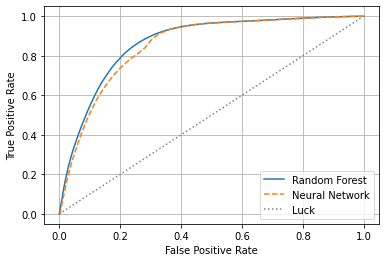

In [59]:
# 16. ROC curve

from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, decisions_rf) # get FPRs, TPRs and thresholds for random forest
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, decisions_nn) # get FPRs, TPRs and thresholds for neural network

plt.plot(fpr_rf, tpr_rf, label='Random Forest') # plot random forest ROC
plt.plot(fpr_nn, tpr_nn, linestyle='dashed', label='Neural Network') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

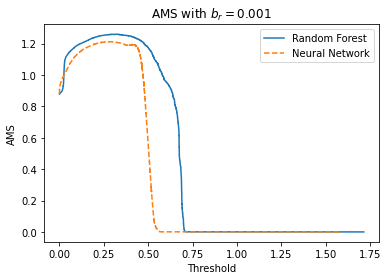

In [60]:
# 17. AMS for the best threshold

def AMS(tpr, fpr, b_reg): # define function to calculate AMS
    return np.sqrt(2*((tpr+fpr+b_reg)*np.log(1+tpr/(fpr+b_reg))-tpr)) # equation for AMS
ams_rf = AMS(tpr_rf, fpr_rf, 0.001) # get AMS for random forest classifier
ams_nn = AMS(tpr_nn, fpr_nn, 0.001) # get AMS for neural network

plt.plot(thresholds_rf, ams_rf, label='Random Forest') # plot random forest AMS
plt.plot(thresholds_nn, ams_nn, linestyle='dashed', label='Neural Network') # plot neural network AMS
plt.xlabel('Threshold') # x-axis label
plt.ylabel('AMS') # y-axis label
plt.title('AMS with $b_r=0.001$') # add plot title
plt.legend() # add legend

## Real ATLAS data
Notice that we’ve trained and tested our machine learning models on simulated data for signal and background. That’s why there are definite labels, y. This has been a case of supervised learning since we knew the labels (y) going into the game. Your machine learning models would then usually be applied to real experimental data once you’re happy with them.

In [109]:
DataFrames['data'] = pd.read_csv('./Data/data.csv')

#DataFrames['data'][ML_inputs]
DataFrames['data'][ML_inputs].values.shape

(832, 2)

In [112]:
# 18. ATLAS real Data 

# Read Data file
DataFrames['data'] = pd.read_csv('./Data/data.csv')

# Apply cuts
DataFrames['data'] = DataFrames['data'][ np.vectorize(cut_lep_type)(DataFrames['data'].lep_type_0,
                                                                    DataFrames['data'].lep_type_1,
                                                                    DataFrames['data'].lep_type_2,
                                                                    DataFrames['data'].lep_type_3) ]
DataFrames['data'] = DataFrames['data'][ np.vectorize(cut_lep_charge)(DataFrames['data'].lep_charge_0,
                                                                      DataFrames['data'].lep_charge_1,
                                                                      DataFrames['data'].lep_charge_2,
                                                                      DataFrames['data'].lep_charge_3) ]

X_data = DataFrames['data'][ML_inputs].values # .values converts straight to NumPy array
X_data_scaled = scaler.transform(X_data) # scale X_data

y_data_RF = RF_clf.predict(X_data_scaled) # make predictions on the data
#out_data, prob_data = NN_clf(X_data_scaled) # get output and probabilities from X_test
#y_data_NN = prob_data.cpu().detach().numpy().argmax(axis=1) # get signal/background predictions

91
416


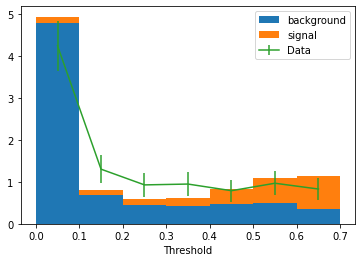

In [81]:
labels = ['background','signal'] # labels for simulated data
thresholds = [] # define list to hold random forest classifier probability predictions for each sample
for s in samples: # loop over samples
    thresholds.append(RF_clf.predict_proba(scaler.transform(DataFrames[s][ML_inputs]))[:,1]) # predict probabilities for each sample
plt.hist(thresholds, bins=np.arange(0, 0.8, 0.1), density=True, stacked=True, label=labels) # plot simulated data
data_hist = np.histogram(RF_clf.predict_proba(X_data_scaled)[:,1], bins=np.arange(0, 0.8, 0.1), density=True)[0] # histogram the experimental data
scale = sum(RF_clf.predict_proba(X_data_scaled)[:,1]) / sum(data_hist) # get scale imposed by density=True
data_err = np.sqrt(data_hist * scale) / scale # get error on experimental data
plt.errorbar(x=np.arange(0.05, 0.75, 0.1), y=data_hist, yerr=data_err, label='Data') # plot the experimental data errorbars
plt.xlabel('Threshold')
plt.legend() 

DataFrames['data'].shape
print(np.count_nonzero(y_data_RF==1))
print(np.count_nonzero(y_data_RF==0))

In [84]:
# 19. TF for NN model

from tensorflow import keras # tensorflow wrapper
from tensorflow.random import set_seed # import set_seed function for TensorFlow
set_seed(seed_value) # set TensorFlow random seed

# Function to build the NN model
def build_model(n_hidden=1, n_neurons=5, learning_rate=1e-3): # function to build a neural network model
    # Build
    model = keras.models.Sequential() # initialise the model
    for layer in range(n_hidden): # loop over hidden layers
        model.add(keras.layers.Dense(n_neurons, activation="relu")) # add layer to your model
    model.add(keras.layers.Dense(2, activation='softmax')) # add output layer
    # Compile
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate) # define the optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # compile your model
    return model

# Define train and validation X and Y
X_valid_scaled, X_train_nn_scaled = X_train_scaled[:100], X_train_scaled[100:] # first 100 events for validation
y_valid, y_train_nn = y_train[:100], y_train[100:] # first 100 events for validation

# Train the NN model
tf_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model) # call the build_model function defined earlier
tf_clf.fit(X_train_nn_scaled, y_train_nn, validation_data=(X_valid_scaled, y_valid), epochs=10) # fit your neural network

# Compute accuracy -- should be the same for pytorch
y_pred_tf = tf_clf.predict(X_test_scaled)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_tf)))

Epoch 1/5
14348/14348 [==============================] - 7s 508us/step - loss: 0.4510 - accuracy: 0.7613 - val_loss: 0.4316 - val_accuracy: 0.7100
Epoch 2/5
14348/14348 [==============================] - 7s 488us/step - loss: 0.4170 - accuracy: 0.7539 - val_loss: 0.4204 - val_accuracy: 0.7200
Epoch 3/5
14348/14348 [==============================] - 7s 498us/step - loss: 0.4126 - accuracy: 0.7639 - val_loss: 0.4135 - val_accuracy: 0.7200
Epoch 4/5
14348/14348 [==============================] - 7s 490us/step - loss: 0.4091 - accuracy: 0.7645 - val_loss: 0.4089 - val_accuracy: 0.7200
Epoch 5/5
14348/14348 [==============================] - 7s 485us/step - loss: 0.4058 - accuracy: 0.7652 - val_loss: 0.4044 - val_accuracy: 0.7200


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.7673453146760395


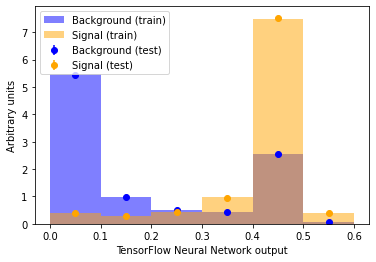

In [86]:
compare_train_test(tf_clf, X_train_nn_scaled, y_train_nn, X_test_scaled, y_test, 'TensorFlow Neural Network output')

              precision    recall  f1-score   support

  background       0.77      0.99      0.87    172891
      signal       0.60      0.04      0.07     53294

    accuracy                           0.77    226185
   macro avg       0.68      0.52      0.47    226185
weighted avg       0.73      0.77      0.68    226185



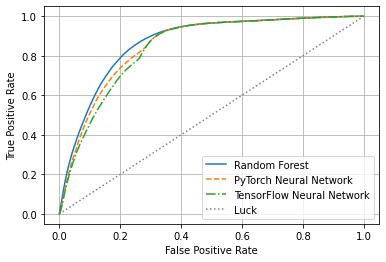

In [88]:
# 20. TF Neural Network Report and ROC curve

print (classification_report(y_test, y_pred_tf,
                            target_names=["background", "signal"]))

decisions_tf = tf_clf.predict_proba(X_test_scaled)[:,1] # get the decisions of the TensorFlow neural network
fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test, decisions_tf) # get FPRs, TPRs and thresholds for TensorFlow neural network

plt.plot(fpr_rf, tpr_rf, label='Random Forest') # plot random forest ROC
plt.plot(fpr_nn, tpr_nn, linestyle='dashed', label='PyTorch Neural Network') # plot PyTorch neural network ROC
plt.plot(fpr_tf, tpr_tf, linestyle='dashdot', label='TensorFlow Neural Network') # plot TensorFlow neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

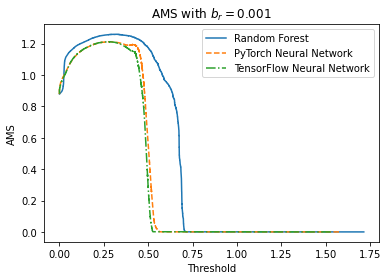

In [89]:
# 21. TF AMS computation

ams_tf = AMS(tpr_tf, fpr_tf, 0.001) # get AMS for TensorFlow neural network

plt.plot(thresholds_rf, ams_rf, label='Random Forest') # plot random forest AMS
plt.plot(thresholds_nn, ams_nn, linestyle='dashed', label='PyTorch Neural Network') # plot PyTorch neural network AMS
plt.plot(thresholds_tf, ams_tf, linestyle='dashdot', label='TensorFlow Neural Network') # plot TensorFlow neural network AMS
plt.xlabel('Threshold') # x-axis label
plt.ylabel('AMS') # y-axis label
plt.title('AMS with $b_r=0.001$') # add plot title
plt.legend() # add a legend